In [1]:
import pandas as pd
import os, math
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

/home/sasse/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [5]:
base_dir = '../../data/pancancer/TCGA/mutation/download_new/'
ultra_mutator_file = '../../data/pancancer/TCGA/mutation/ultramutated_tumor_ids'
all_qvalues = []
ctypes = []

# scan through directories to find the mutsigcv result files
for dname in os.listdir(base_dir):
    ctype_dir = os.path.join(base_dir, dname)
    if os.path.isdir(ctype_dir):
        for mutsigcvfile in os.listdir(ctype_dir):
            if mutsigcvfile.endswith('.sig_genes.txt'):
                # get the cancer type (study name from TCGA)
                ctype = mutsigcvfile.split('.')[1]
                ctypes.append(ctype)
                # get the q-values from mutsigcv
                full_path = os.path.join(base_dir, dname, mutsigcvfile)
                mutsigcv_qvalues = pd.read_csv(full_path, sep='\t').set_index('gene').q
                all_qvalues.append(mutsigcv_qvalues)

# create dataframe with all information inside
gene_ctype_matrix = pd.DataFrame(all_qvalues, index=ctypes).T
smallest_qvalue = gene_ctype_matrix[gene_ctype_matrix != 0].min().min()
print ("Smallest q-value in the data (0 will be replaced with it): {}".format(smallest_qvalue))
# take the -log10 of the q-values, according to what they did for HotNet2
gene_ctype_matrix_nozero = gene_ctype_matrix.replace(0, smallest_qvalue)
mutation_matrix = -np.log10(gene_ctype_matrix_nozero)

Smallest q-value in the data (0 will be replaced with it): 1.4957879999999997e-13


In [10]:
gene_ctype_matrix.mean(axis=1).to_csv('../../data/pancancer/mutsigcv/mutsigcv_qvalues_mean.csv', sep='\t')

<BarContainer object of 30 artists>

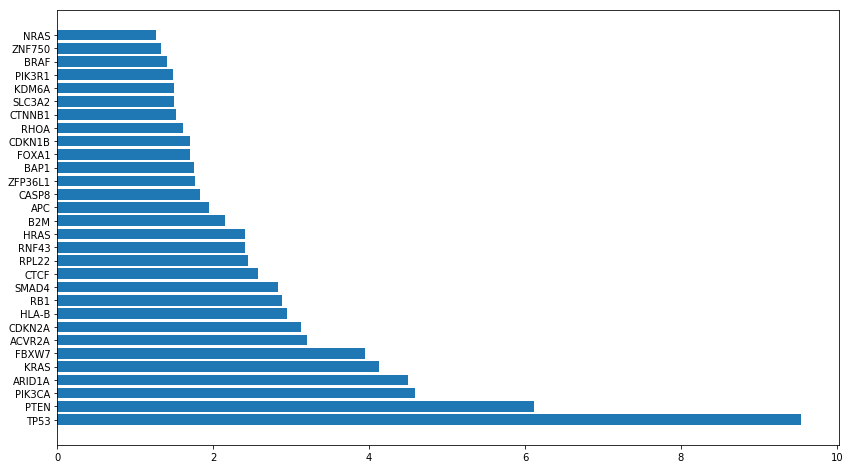

In [4]:
fig = plt.figure(figsize=(14, 8))
most_highly_mutated_genes = mutation_matrix.mean(axis=1).sort_values(ascending=False).head(30)
plt.barh(y=most_highly_mutated_genes.index,
         width=most_highly_mutated_genes)

In [5]:
mutation_matrix.to_csv('../../data/pancancer/mutsigcv/mutsigcv_genescores.csv', sep='\t')

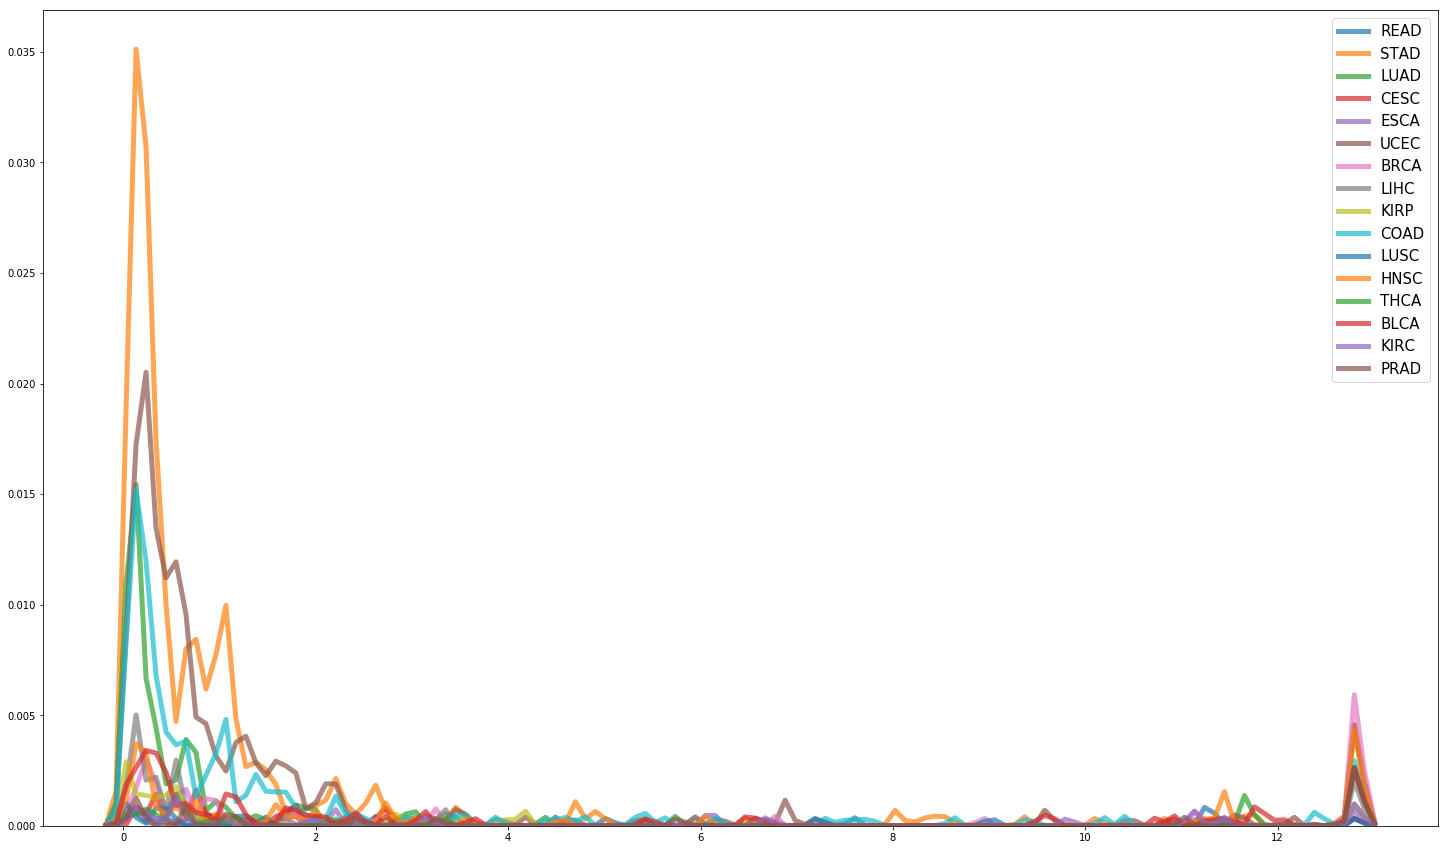

In [6]:
fig = plt.figure(figsize=(25, 15))
for col in mutation_matrix.columns:
    sns.kdeplot(mutation_matrix[col], alpha=.7, label=col, bw=0.06, lw=5)
plt.legend(fontsize=15)

Text(0.5, 1.0, '20 Longest Proteins')

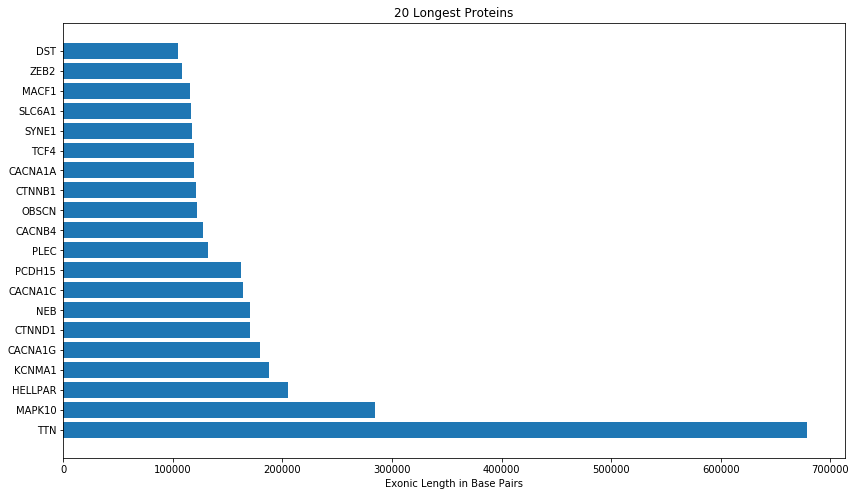

In [7]:
annotation_gencode = pd.read_csv('../../data/pancancer/gencode/gencode.v28.basic.annotation.gff3',
                                 comment='#', sep='\t', skiprows=7,header=None,
                                 names=['chr', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attr']
                                )
# derive length of all exons
annotation_gencode = annotation_gencode[annotation_gencode.type == 'exon']
annotation_gencode['length'] = np.abs(annotation_gencode.end - annotation_gencode.start)
# extract the gene name for each exon
def get_hugo_symbol(row):
    s = row.attr
    for elem in s.split(';'):
        if elem.startswith('gene_name'):
            return elem.split('=')[1].strip()
    return None
annotation_gencode['Hugo_Symbol'] = annotation_gencode.apply(get_hugo_symbol, axis=1)
# add length of exons together for each gene
exonic_gene_lengths = annotation_gencode.groupby('Hugo_Symbol').length.sum()

# plot the longest proteins at the end
fig = plt.figure(figsize=(14, 8))
plt.barh(y = range(20), width=exonic_gene_lengths.sort_values(ascending=False).head(20), tick_label=exonic_gene_lengths.sort_values(ascending=False).head(20).index)
plt.xlabel('Exonic Length in Base Pairs')
plt.title('20 Longest Proteins')

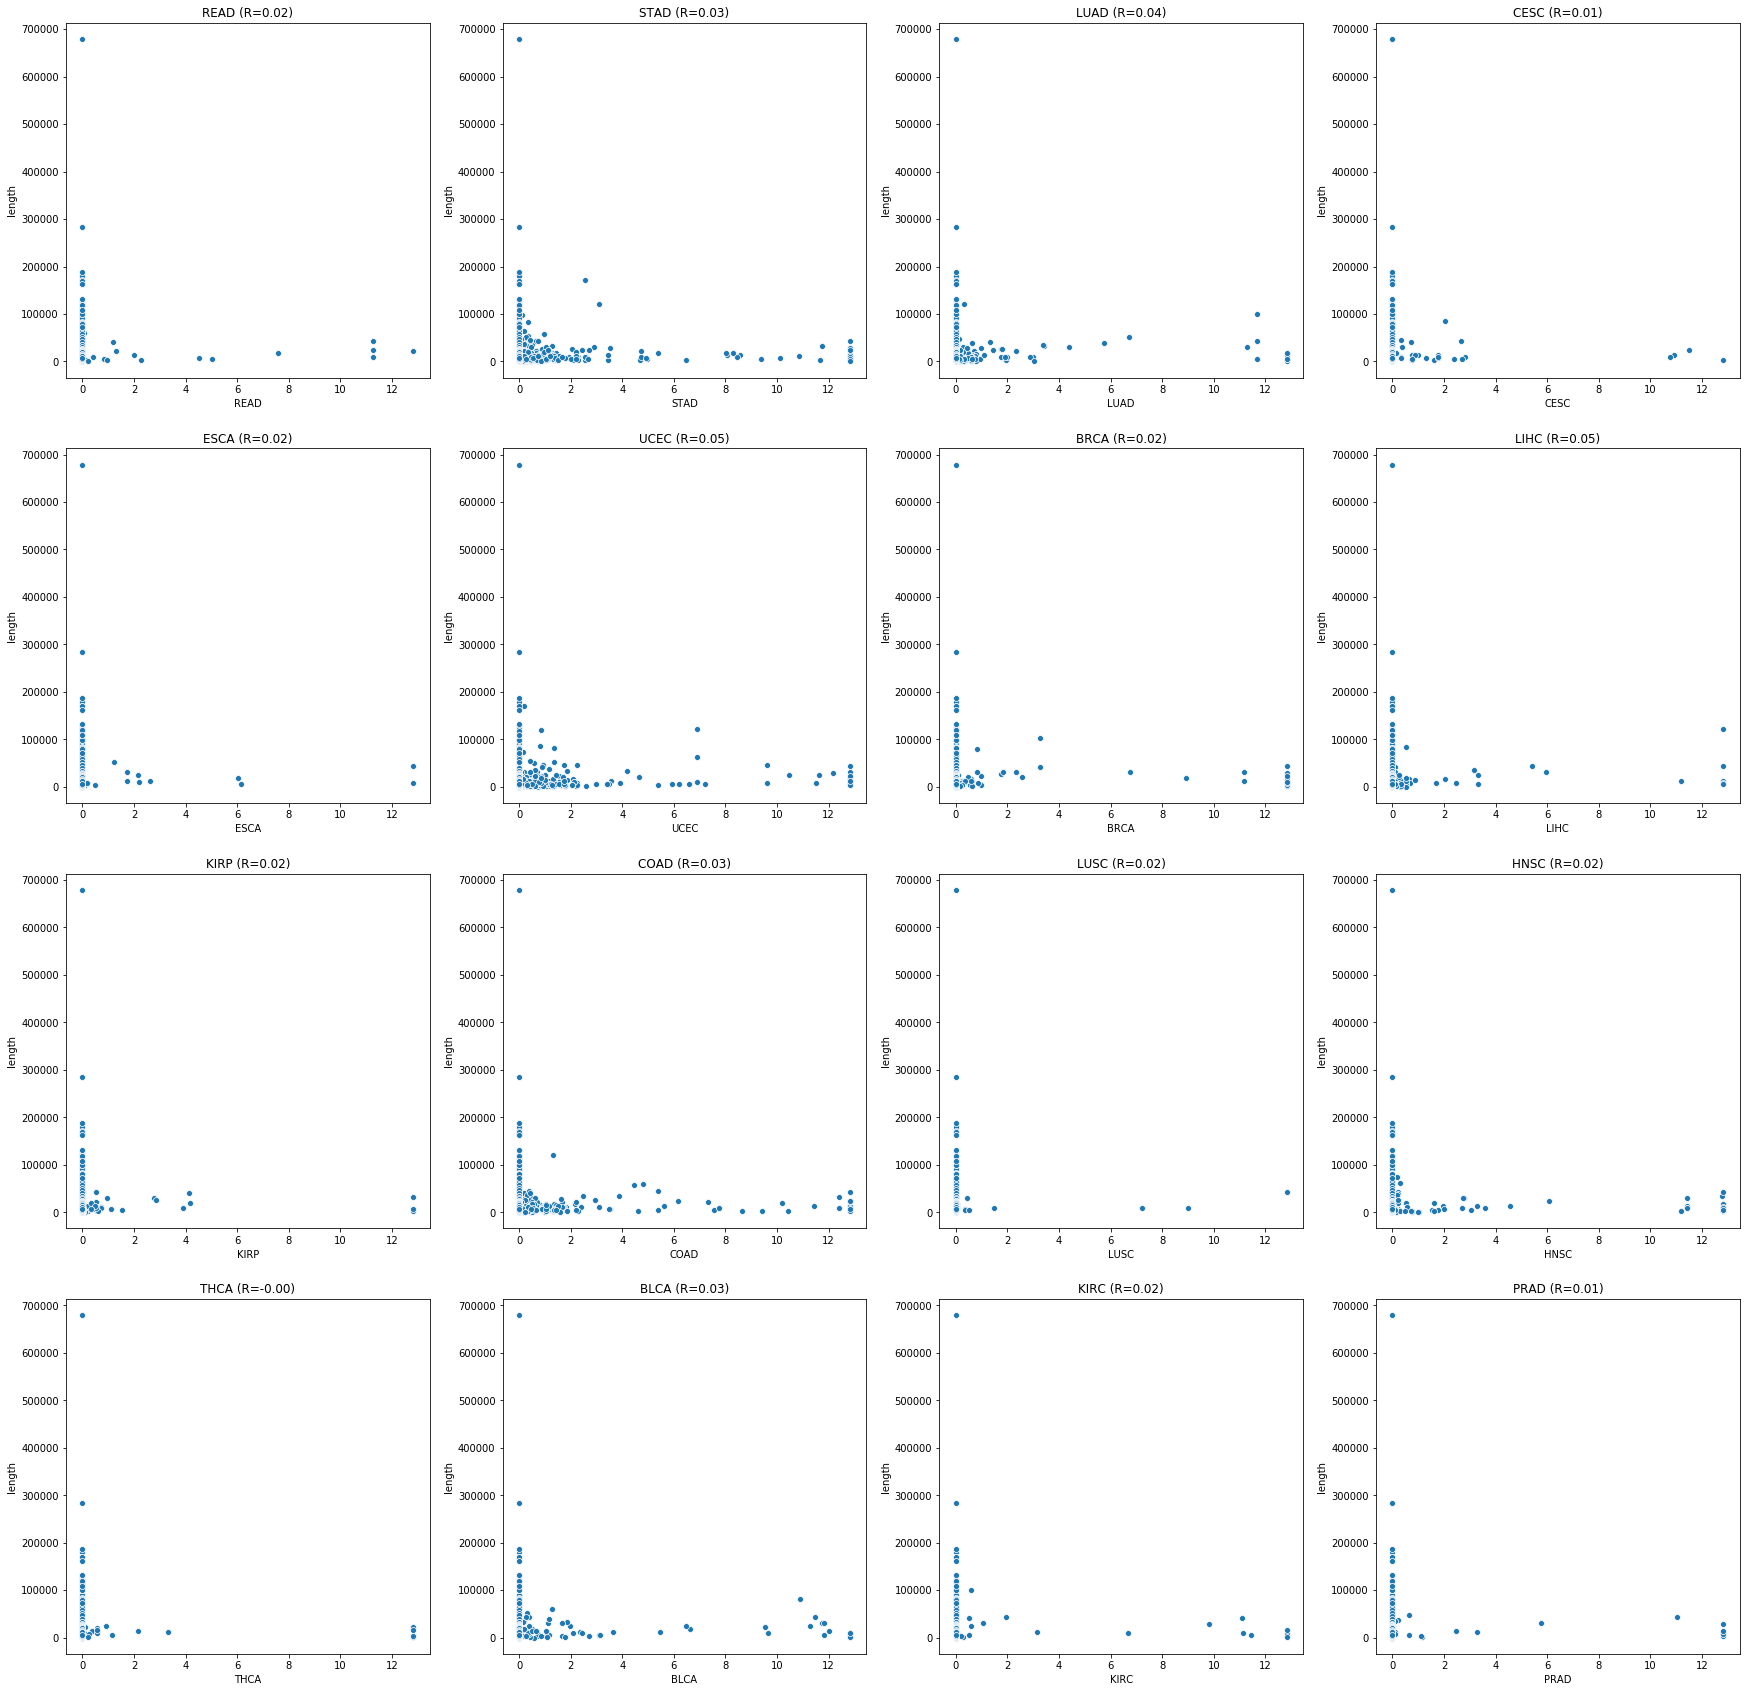

In [17]:
bestSplit = lambda x: (round(math.sqrt(x)), math.ceil(x / round(math.sqrt(x))))

length_and_mean_matrix = mutation_matrix.join(exonic_gene_lengths).dropna(axis=0)
fig = plt.figure(figsize=(30, 30))
x, y = bestSplit(mutation_matrix.shape[1])
for i in range(mutation_matrix.shape[1]):
    plt.subplot(x, y, i+1)
    sns.scatterplot(length_and_mean_matrix.iloc[:, i], length_and_mean_matrix.length)
    plt.title('{0} (R={1:.2f})'.format(mutation_matrix.columns[i],
                                 length_and_mean_matrix.iloc[:, i].corr(length_and_mean_matrix.length)))
fig.savefig('../../data/pancancer/TCGA/mutation/mutation_length_correlation_mutsigcv.png', dpi=300)